# Install pymt and the Child plug-in

Use the conda command to install the complete CSDMS software stack,
```bash
$ conda install csdms-stack -c conda-forge -c csdms-stack
```

Define a function to plot some child output. We'll use this later on.

In [1]:
import matplotlib.pyplot as plt

def plot_tris(x, y, tris, val):
    plt.tripcolor(x, y, z, edgecolors='k', vmin=-200, vmax=200)
    plt.gca().set_aspect('equal')
    plt.colorbar()
    plt.show()

# Run a general PyMT model

Import the `Child` component from `pymt`. All of the components available to `pymt` are located in `pymt.components`.

In [2]:
from pymt.components import Child as Model

The following code is generic for all `pymt` components - not just `Child`. First we instantiate the component and then call its `setup` method to create a model simulation with any input files. `setup` takes an optional argument that gives a path to a folder that will contain the necessary input files (if not provided, a temporary folder will be used). `setup` return the name of the config file and the path to the folder containing it.

In [3]:
model = Model()
config_file, initdir = model.setup('_model')

Now that we have a valid config file, we can initialize the model, which brings it to the point that we can start time stepping.

In [4]:
model.initialize(config_file, dir=initdir)

We now update it for 10 time steps, and then clean up with the `finalize` method.

In [5]:
for _ in xrange(10):
    model.update()
model.finalize()

# Run the CHILD model

Now we will run the Child model and look at some real output. As before, first import the `Child` class and instantiate it.

In [6]:
from pymt.components import Child as Model
model = Model()

We run `setup` and `initialize` as before but notice we can pass keywords to `setup`. In this case, we set the grid spacing to 500 m through a keyword to `setup`. Use `help(model)` to get a full list of possible keywords.

In [7]:
model.initialize(*model.setup('_model', grid_node_spacing=500.))

As with all `pymt` components you can get a list of the names of all the input and output variables. Here we get all of the output variables with the `output_var_names` attribute.

In [8]:
model.output_var_names

('surface__elevation',
 'sea_floor__elevation',
 'surface__elevation_increment',
 'sediment__erosion_rate',
 'channel_water__discharge',
 'bed_load__mass_flow_rate')

The `get_value` method takes the name of an output item and returns an array of values for that variable.

In [9]:
z = model.get_value('surface__elevation')

Every variable is attached to a grid that defines where variables are defined and how they are connected to their neighbors. Each grid is given an id, which is passed to the BMI `get_grid_*` methods. Use `get_var_grid` to get the grid id for a particular variable.

In [10]:
model.get_var_grid('surface__elevation')

0

With the grid id, we can now get information about that grid. For instance, the *x* and *y* coordinates of each grid node and how nodes and faces are connected to one another.

In [11]:
x, y = model.get_grid_x(0), model.get_grid_y(0)
tris = model.get_grid_face_node_connectivity(0).reshape((-1, 3))

We now use the function we defined at the top of this notebook to plot surface elevations on the child grid. We notice that child has initialized its elevations with some random noise.

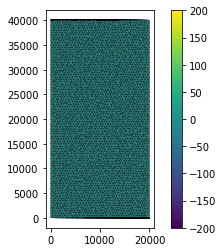

In [12]:
plot_tris(x, y, tris, z)

We would like to run child with some real topography. To see if we able to set the elevations of child, we can look at the list of input variables. Fortunately, `surface__elevation` is an input variable, which means we can set it.

In [13]:
model.input_var_names

('surface__elevation',
 'sea_floor__elevation',
 'sea_floor_bedrock_surface__elevation',
 'bedrock_surface__elevation',
 'bedrock_surface__elevation_increment')

For this example, we'll set a shoreline at `y=10000.` and add some land and an ocean.

In [14]:
y_shore = 10000.
z[y > y_shore] += 100
z[y <= y_shore] -= 100

Use the `set_value` method to set the elevations, and then `get_value` to get them to make sure they were set correctly.

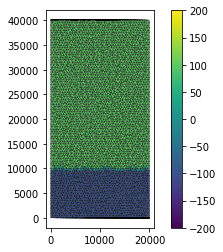

In [15]:
model.set_value('surface__elevation', z)
z = model.get_value('surface__elevation')
plot_tris(x, y, tris, z)

The elevations look good so lets run for 5000 years (this may take a minute or so - on my not-all-that-fast computer this takes about 30s).

In [16]:
model.update_until(5000.)

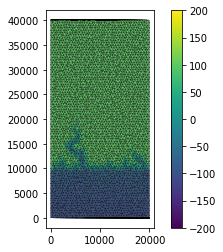

In [17]:
z = model.get_value('surface__elevation')
plot_tris(x, y, tris, z)

Let's do something a little fancier this time. Now we will advance the model for an additions 5000 years but, this time, every 100 years we'll uplift a block in the upper-right corner of the grid at a rate of .02 m/y.

In [18]:
dz_dt = .02
now = int(model.get_current_time())
for t in xrange(now, now + 5000, 100):
    model.update_until(t)
    z = model.get_value('surface__elevation')
    z[(y > 15000) & (x > 10000)] += dz_dt * 100.
    model.set_value('surface__elevation', z)

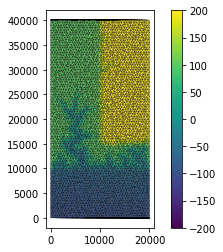

In [19]:
plot_tris(x, y, tris, z)

In [20]:
model.update_until(model.get_current_time() + 10000.)

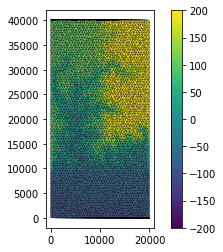

In [21]:
z = model.get_value('surface__elevation')
plot_tris(x, y, tris, z)